# Generar vectores caracteristicos

In [28]:
%pip install opencv-python matplotlib numpy scipy tqdm scikit-learn Rtree

# Establecer paths 

In [29]:
import os
from tqdm import tqdm

directory_path = os.path.join("F:/", "DB2_Proyect", "portraits") # Folder de imagen en carpeta portraits
images_names = os.listdir(directory_path)
path = "D:\Semestre_2024_2_CS\BD_2\Projects\Proyecto3"


# Probar si se puede acceder a las imagenes 

10085920.jpg


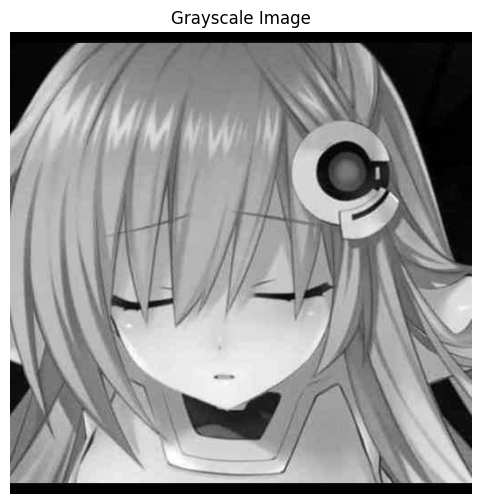

In [30]:
from skimage.feature import hog
from skimage import color, io
import numpy as np
import matplotlib.pyplot as plt
import os

# Ruta de la imagen
image_index = 543
image_path = os.path.join(directory_path, images_names[image_index])

# Cargar la imagen y convertirla a escala de grises
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

# Mostrar la imagen en escala de grises
print(images_names[image_index])
plt.figure(figsize=(8, 6))
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()


# Extraer features locales ya procesados (procesados por Embedding_local)

In [31]:
file_name = "descriptors_color_2_opencv.npz"
load_path = os.path.join(os.getcwd(), "data",file_name)
features = np.load(load_path)


# Extraer feature vector de elementos flatenned de features por imagen

In [32]:
index = 'data/index_dict_color_cv.npz'
vector ='data/feature_vector_color_cv.npy'
path = "D:/Semestre_2024_2_CS/BD_2/Projects/Proyecto3"

# Cargar el diccionario desde el archivo .npz
data_dict = np.load(os.path.join(path,index), allow_pickle=True)
index_dict = data_dict['arr_0'].item()  # .item() para convertir a diccionario
# Cargar el array desde el archivo .npy
feature_vector = np.load(os.path.join(path,vector))


In [33]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """
    Calcula la similitud de coseno entre dos vectores.

    Parameters:
    vec1 (np.ndarray): Primer vector.
    vec2 (np.ndarray): Segundo vector.

    Returns:
    float: Valor de la similitud de coseno entre vec1 y vec2.
    """
    # Calcula el producto punto de los dos vectores
    dot_product = np.dot(vec1, vec2)
    
    # Calcula la norma (magnitud) de cada vector
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Calcula y retorna la similitud de coseno
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0  # Retorna 0 si alguno de los vectores es cero
    return dot_product / (norm_vec1 * norm_vec2)


# Generador de feature vector para query

In [34]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import multiprocessing
from skimage.feature import local_binary_pattern
from skimage import io, color
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler

def extract_lbp_features(cell_image, P=8, R=1, method='uniform', bins=4):
    lbp_features = []
    for channel in range(3):  # RGB
        lbp = local_binary_pattern(cell_image[:, :, channel], P=P, R=R, method=method)
        # Calcular histograma
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        # Normalizar
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.extend(hist)
    return np.array(lbp_features)  # 3 canales * 4 bins = 12

def extract_color_histogram(cell_image, bins=4):
    color_hist = []
    for channel in range(3):  # RGB
        hist, _ = np.histogram(cell_image[:, :, channel], bins=bins, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        color_hist.extend(hist)
    return np.array(color_hist)  # 3 canales * 4 bins = 12

def extract_hog_features_opencv(gray_cell, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1)):
    winSize = (gray_cell.shape[1] // pixels_per_cell[1] * pixels_per_cell[1],
               gray_cell.shape[0] // pixels_per_cell[0] * pixels_per_cell[0])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                            _blockSize=(pixels_per_cell[1]*cells_per_block[1],
                                        pixels_per_cell[0]*cells_per_block[0]),
                            _blockStride=(pixels_per_cell[1], pixels_per_cell[0]),
                            _cellSize=pixels_per_cell,
                            _nbins=orientations)
    hog_features = hog.compute(gray_cell)
    hog_features = hog_features.flatten()
    # Reducir a 4 dimensiones si es necesario
    if len(hog_features) > orientations:
        hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
    elif len(hog_features) < orientations:
        hog_features = np.pad(hog_features, (0, orientations - len(hog_features)), 'constant')
    return hog_features

def process_image_opencv(image_path, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1), 
                        P=8, R=1, lbp_bins=4, color_bins=4):
    image = io.imread(image_path)
    
    # Validar que la imagen sea RGB
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError(f"La imagen {image_path} no es RGB o no tiene 3 canales.")
    
    # Validar tamaño de la imagen (512x512)
    if image.shape[0] != 512 or image.shape[1] != 512:
        raise ValueError(f"La imagen {image_path} no tiene tamaño 512x512. Tamaño actual: {image.shape[:2]}")
    
    # Dividir la imagen en una cuadrícula de 8x8 (64 celdas de 64x64)
    grid_size = 8
    cell_height = image.shape[0] // grid_size
    cell_width = image.shape[1] // grid_size
    
    feature_matrix = []
    
    for row in range(grid_size):
        for col in range(grid_size):
            # Definir las coordenadas de la celda
            start_y = row * cell_height
            end_y = (row + 1) * cell_height
            start_x = col * cell_width
            end_x = (col + 1) * cell_width
            
            # Extraer la celda
            cell = image[start_y:end_y, start_x:end_x]
            
            # Convertir a escala de grises para HOG
            gray_cell = color.rgb2gray(cell)
            gray_cell_uint8 = (gray_cell * 255).astype('uint8')  # Convertir a uint8 para OpenCV
            
            # Extraer HOG usando OpenCV
            hog_features = extract_hog_features_opencv(gray_cell_uint8, orientations, pixels_per_cell, cells_per_block)
            # Asegurar que HOG contribuye con 4 dimensiones
            if len(hog_features) != orientations:
                # Reducir dimensionalidad de HOG mediante promedio si es necesario
                hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
            
            # Extraer LBP
            lbp_features = extract_lbp_features(cell, P=P, R=R, method='uniform', bins=lbp_bins)
            # Reducir LBP a 4 dimensiones
            if len(lbp_features) > 4:
                lbp_features = lbp_features[:4]  # Seleccionar las primeras 4 dimensiones
            elif len(lbp_features) < 4:
                lbp_features = np.pad(lbp_features, (0, 4 - len(lbp_features)), 'constant')
            
            # Extraer Histograma de Color Local
            color_hist = extract_color_histogram(cell, bins=color_bins)
            # Reducir color_hist a 8 dimensiones
            if len(color_hist) > 8:
                color_hist = color_hist[:8]  # Seleccionar las primeras 8 dimensiones
            elif len(color_hist) < 8:
                color_hist = np.pad(color_hist, (0, 8 - len(color_hist)), 'constant')
            
            # Concatenar HOG + LBP + Color Histogram
            feature_vector = np.concatenate([hog_features, lbp_features, color_hist])
            # Asegurar que el feature_vector tiene exactamente 16 dimensiones
            if feature_vector.shape[0] != 16:
                raise ValueError(f"El vector de características de la celda ({row}, {col}) no tiene 16 dimensiones. Tiene {feature_vector.shape[0]} dimensiones.")
            
            feature_matrix.append(feature_vector)
    
    feature_matrix = np.array(feature_matrix)  # Shape: (64, 16)
    
    return image_path, feature_matrix.flatten() 


# Algoritmo Knn con preproceso de normalizacion de vectores de la coleccion

In [ ]:
import numpy as np
import os

def prepare_knn_model(centroids_matrix):
    """
    Prepara el modelo KNN normalizando los centroides.
    
    Parámetros:
    - centroids_matrix (np.ndarray): Matriz donde cada fila es el centroide de una imagen.
    
    Retorna:
    - normalized_centroids (np.ndarray): Matriz de centroides normalizados.
    """
    # Calcular las normas de cada centroid
    norms = np.linalg.norm(centroids_matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Evitar división por cero
    
    # Normalizar los centroides
    normalized_centroids = centroids_matrix / norms
    return normalized_centroids

def find_knn_cosine_optimized(normalized_centroids, index_map, query_centroid, directory_path, k=5):
    """
    Encuentra los K vecinos más cercanos utilizando similitud de coseno optimizada.
    
    Parámetros:
    - normalized_centroids (np.ndarray): Matriz de centroides normalizados.
    - index_map (dict): Mapa de nombres de imágenes a índices en normalized_centroids.
    - query_centroid (np.ndarray): Vector de consulta (no normalizado).
    - directory_path (str): Ruta al directorio donde se encuentran las imágenes.
    - k (int): Número de vecinos más cercanos a encontrar.
    
    Retorna:
    - list: Lista de rutas de las K imágenes más cercanas (con ".jpg" añadido).
    """
    # Normalizar el vector de consulta
    query_norm = np.linalg.norm(query_centroid)
    if query_norm == 0:
        raise ValueError("El vector de consulta tiene norma cero.")
    normalized_query = query_centroid / query_norm
    
    # Calcular similitudes de coseno como producto punto
    similarities = normalized_centroids @ normalized_query
    
    # Encontrar los índices de los K mayores valores de similitud
    if k >= len(similarities):
        top_k_indices = np.argsort(-similarities)[:k]
    else:
        top_k_indices = np.argpartition(-similarities, k)[:k]
        # Ordenar los top K índices por similitud
        top_k_indices = top_k_indices[np.argsort(-similarities[top_k_indices])]
    
    # Crear un mapa inverso para obtener nombres a partir de índices
    inv_index_map = {idx: name for name, idx in index_map.items()}
    
    # Obtener los nombres de las imágenes correspondientes y construir las rutas
    knn_results = [os.path.join(directory_path, inv_index_map[idx] + ".jpg") for idx in top_k_indices]
    
    return knn_results

def find_knn_cosine_by_radio(normalized_centroids, index_map, query_centroid, directory_path, radius):
    """
    Encuentra los vecinos dentro de un radio utilizando similitud de coseno optimizada.
    Retorna un generador que produce las rutas de imágenes de los vecinos encontrados.

    Parámetros:
    - normalized_centroids (np.ndarray): Matriz de centroides normalizados.
    - index_map (dict): Mapa de nombres de imágenes a índices en normalized_centroids.
    - query_centroid (np.ndarray): Vector de consulta (no normalizado).
    - directory_path (str): Ruta al directorio donde se encuentran las imágenes.
    - radius (list o float): Umbral(es) de similitud de coseno para incluir vecinos.

    Retorna:
    - generator: Generador que produce rutas de imágenes dentro del radio.
    """
    # Asegurarse de que radius sea una lista
    if not isinstance(radius, (list, tuple)):
        radius = [radius]

    # Normalizar el vector de consulta
    query_norm = np.linalg.norm(query_centroid)
    if query_norm == 0:
        raise ValueError("El vector de consulta tiene norma cero.")
    normalized_query = query_centroid / query_norm

    # Calcular similitudes de coseno como producto punto
    similarities = normalized_centroids @ normalized_query
#aqui vienen las variaciones para rango 

    # Crear mapa inverso para obtener nombres a partir de índices
    inv_index_map = {idx: name for name, idx in index_map.items()}
#fro en radios
    for r in radius:
        print(f"Buscando imágenes con radio: {r}")
        # simil y fitlro
        for idx, similarity in enumerate(similarities):
            if similarity <= r:  # comparación idnividual con rango
                # ruta
                if idx in inv_index_map:
                    image_path = os.path.join(directory_path, inv_index_map[idx] + ".jpg")
                    yield image_path  # Yield uno a la vez
                else:
                    raise KeyError(f"Índice {idx} no encontrado en el mapa de índices inverso.")





# Graficador de resultados

In [36]:
import os
import matplotlib.pyplot as plt
from skimage import io

def display_images_in_grid(image_paths, grid_rows, grid_cols):
    """
    Muestra las imágenes en una cuadrícula de subplots con el nombre de la imagen como título.

    Parameters:
    image_paths (list): Lista de rutas de imágenes a mostrar.
    grid_rows (int): Número de filas en la cuadrícula.
    grid_cols (int): Número de columnas en la cuadrícula.
    """
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    
    # Aplanar el arreglo de ejes para fácil iteración
    axes = axes.flatten()
    
    # Mostrar cada imagen en su posición correspondiente
    for i, image_path in enumerate(image_paths):
        
        if i < len(axes):  # Para evitar errores si hay más espacios que imágenes
            image = io.imread(image_path)
            
            # Determinar si la imagen es en escala de grises o a color
            if image.ndim == 2:
                # Escala de grises
                axes[i].imshow(image, cmap='gray')
            elif image.ndim == 3:
                # A color (RGB)
                axes[i].imshow(image)
            else:
                raise ValueError(f"La imagen {image_path} tiene un formato inesperado: {image.ndim} dimensiones.")
            
            # Extraer solo el nombre del archivo
            image_name = os.path.basename(image_path)
            
            # Establecer el título con el nombre de la imagen
            axes[i].set_title(image_name)
            axes[i].axis('off')
    
    # Desactivar cualquier subplot vacío
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


# Normalizar vectores con sus normas para agilizar queries

In [37]:
normalized_features = prepare_knn_model(feature_vector)

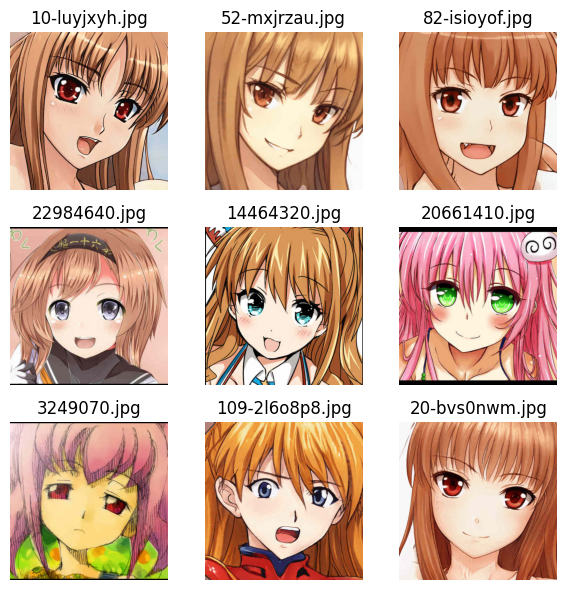

In [38]:

query_path = os.path.join(directory_path , "10-luyjxyh.jpg")
_,query= process_image_opencv(query_path)

results = find_knn_cosine_optimized(normalized_features , index_dict , query ,  directory_path,k=10)
display_images_in_grid(results, grid_rows=3, grid_cols=3)